In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

## Load Dataset

In [11]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

## Definisi Fitur dan Target

In [12]:
features = ['Lag_1_Status', 'Count_Alpa_7D', 'Count_Alpa_30D', 'Streak_Alpa', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

/tmp/ipykernel_154208/3542950029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


## Split Data

In [13]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 89658 baris
Data Uji: 22415 baris


## Class Weight

In [14]:
# For XGBoost & Naive Bayes
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
sample_weights

array([1.25157742, 1.25157742, 1.25157742, ..., 1.25157742, 1.25157742,
       1.25157742])

## Naive Bayes

In [15]:
nb_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', GaussianNB(var_smoothing=1e-09))
])

In [16]:
nb_model.fit(
    X_train, 
    y_train, 
    clf__sample_weight=sample_weights
)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', GaussianNB())])

## Decision Tree

In [17]:
dt_model = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',
    max_depth=25,
    min_samples_leaf=10,
    min_samples_split=20,
    class_weight='balanced',
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

## SVM

In [18]:
svm_model = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(
                random_state=42,
                C=1,
                gamma='scale',
                kernel='rbf',
                class_weight='balanced'
            ))
        ])

svm_model.fit(
    X_train,
    y_train,
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=1, class_weight='balanced', random_state=42))])

## Random Forest

In [19]:
rf_model = RandomForestClassifier(
  random_state=42,
  max_depth=7,
  max_features=3,
  min_samples_split=5,
  n_estimators=50,
  class_weight='balanced'
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=3,
                       min_samples_split=5, n_estimators=50, random_state=42)

## XGBoost

In [20]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    colsample_bytree=0.5, 
    gamma=2, 
    learning_rate=0.2, 
    max_depth=3, 
    min_child_weight=0, 
    n_estimators=180, 
    reg_alpha=20, 
    reg_lambda=1, 
    seed=0
)
xgb_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [21]:
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Naive Bayes': nb_model,
    'SVM': svm_model,
}


Evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     15074
           1       0.44      0.47      0.46      7341

    accuracy                           0.63     22415
   macro avg       0.59      0.59      0.59     22415
weighted avg       0.64      0.63      0.63     22415


Confusion Matrix for Decision Tree:


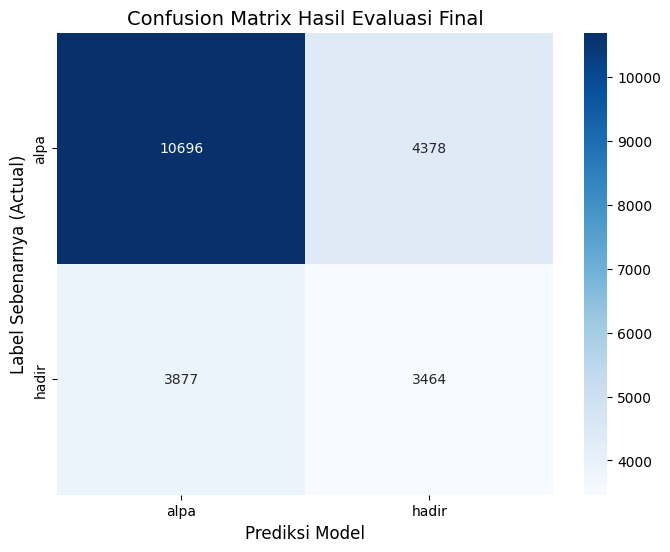


Evaluating Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75     15074
           1       0.49      0.52      0.50      7341

    accuracy                           0.66     22415
   macro avg       0.62      0.63      0.63     22415
weighted avg       0.67      0.66      0.67     22415


Confusion Matrix for Random Forest:


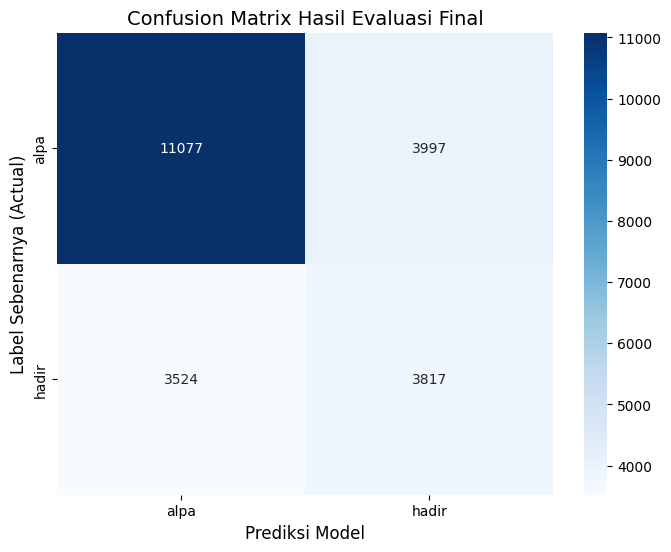


Evaluating XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69     15074
           1       0.42      0.51      0.46      7341

    accuracy                           0.61     22415
   macro avg       0.58      0.58      0.58     22415
weighted avg       0.63      0.61      0.62     22415


Confusion Matrix for XGBoost:


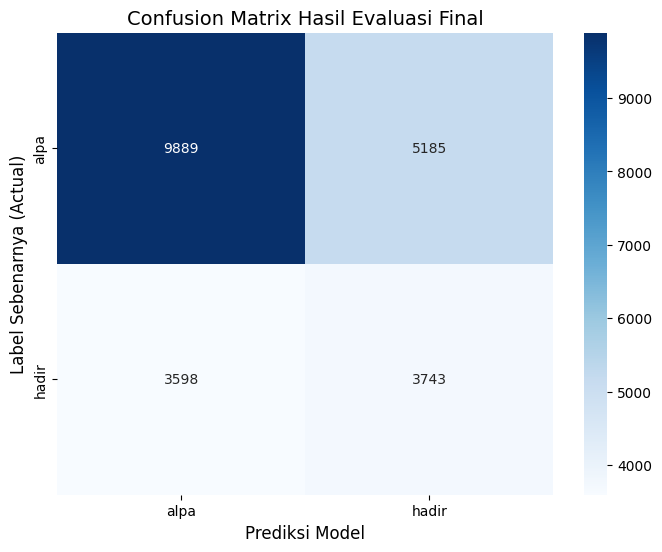


Evaluating Naive Bayes...

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.79      0.58      0.67     15074
           1       0.44      0.68      0.53      7341

    accuracy                           0.61     22415
   macro avg       0.61      0.63      0.60     22415
weighted avg       0.67      0.61      0.62     22415


Confusion Matrix for Naive Bayes:


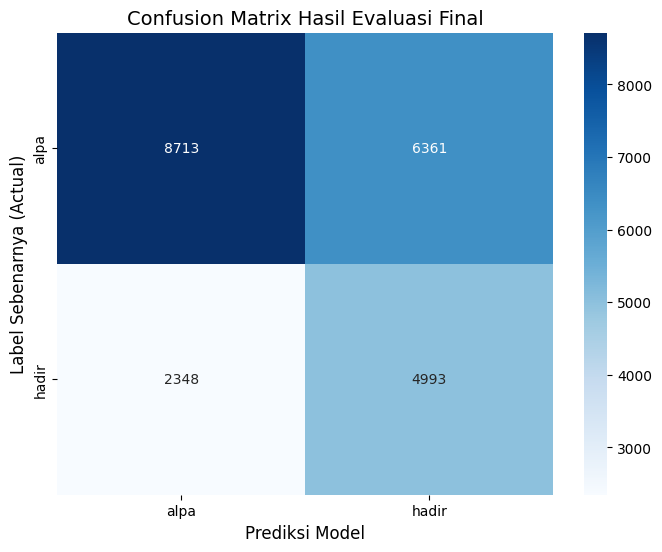


Evaluating SVM...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74     15074
           1       0.48      0.51      0.49      7341

    accuracy                           0.66     22415
   macro avg       0.61      0.62      0.62     22415
weighted avg       0.66      0.66      0.66     22415


Confusion Matrix for SVM:


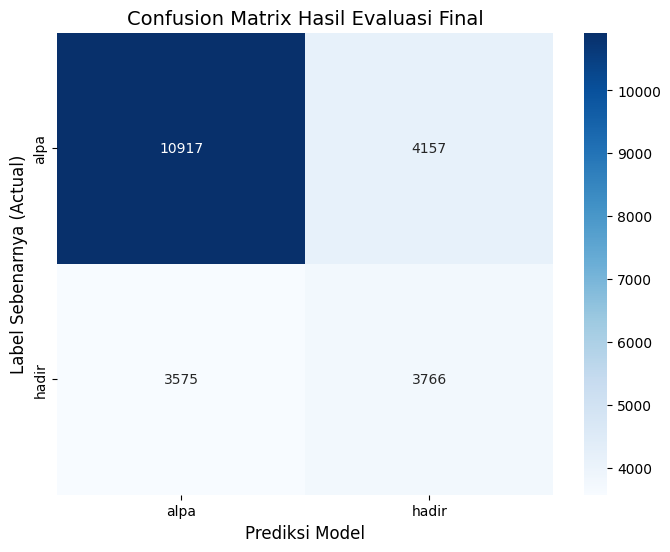

In [22]:
results = []

for name, model in models.items():
  print(f"\n{'='*50}")
  print(f"Evaluating {name}...")
  print('='*50)
  
  # Make predictions
  y_pred = model.predict(X_test)
  
  # Calculate metrics
  report = classification_report(y_test, y_pred, output_dict=True)
    
  # Store results
  results.append({
      'Model': name,
      'Accuracy': report['accuracy'],
      'Macro F1': report['macro avg']['f1-score'],
      'Macro Recall': report['macro avg']['recall'],
      'Macro Precision': report['macro avg']['precision']
  })
  
  # Print classification report
  print(f"\nClassification Report for {name}:")
  print(classification_report(y_test, y_pred))
  
  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print(f"\nConfusion Matrix for {name}:")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.xlabel('Prediksi Model', fontsize=12)
  plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
  plt.title('Confusion Matrix Hasil Evaluasi Final', fontsize=14)
  plt.show()

In [23]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1,Macro Recall,Macro Precision
0,Decision Tree,0.631720,0.588928,0.590718,0.587842
1,Random Forest,0.664466,0.625141,0.627399,0.623564
2,XGBoost,0.608164,0.576311,0.582953,0.576234
3,Naive Bayes,0.611466,0.600461,0.629084,0.613740
4,SVM,0.655052,0.615966,0.618618,0.614319


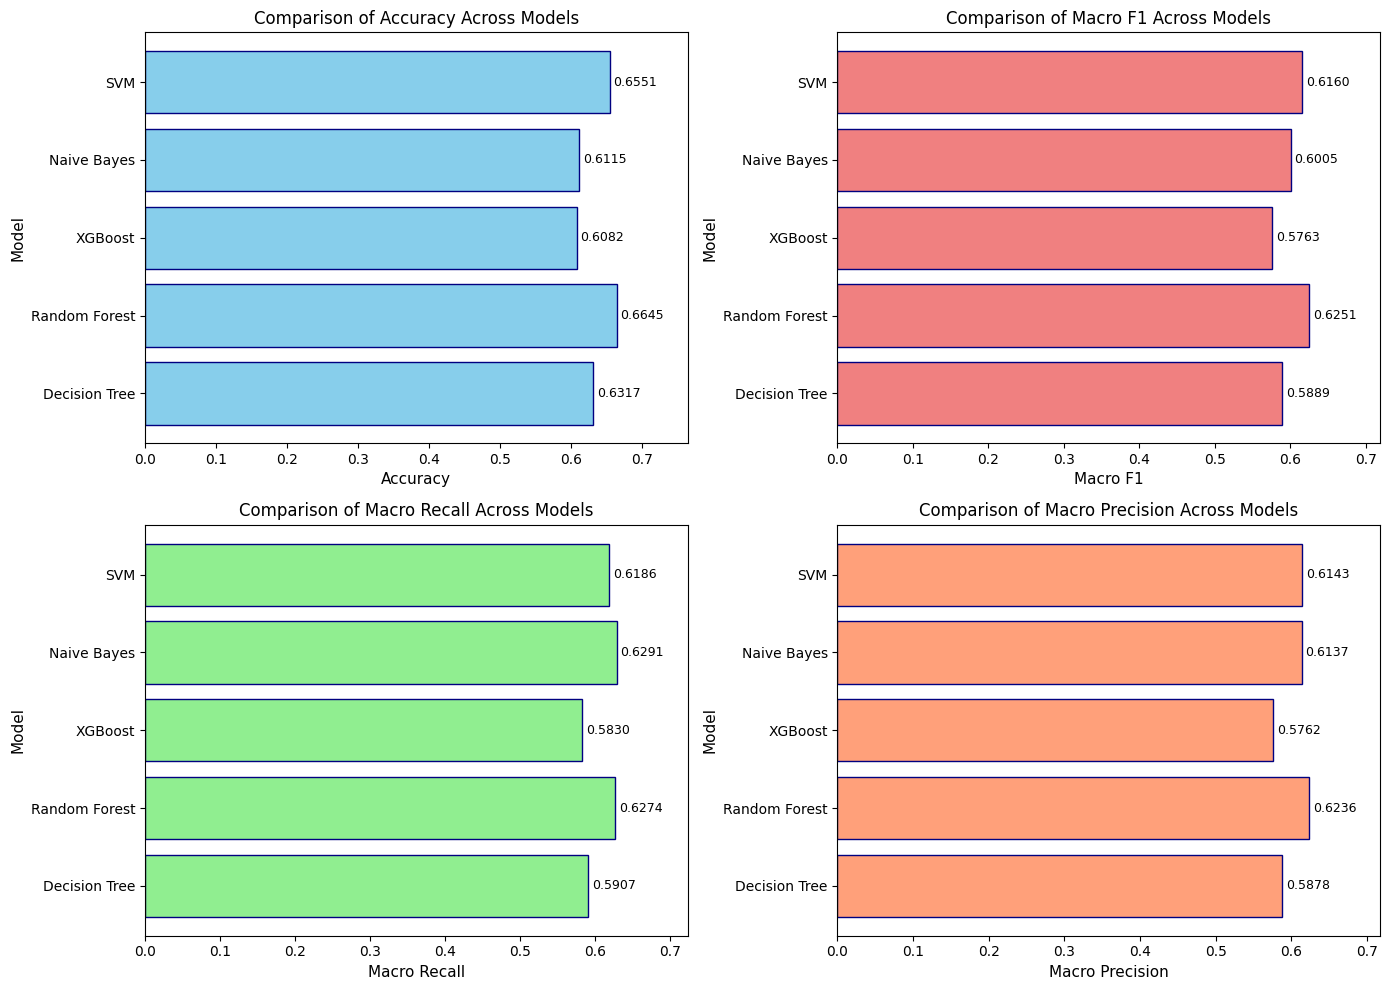

In [24]:
# Create subplots for all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Macro F1', 'Macro Recall', 'Macro Precision']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
  ax.barh(results_df['Model'], results_df[metric], color=color, edgecolor='navy')
  ax.set_xlabel(metric, fontsize=11)
  ax.set_ylabel('Model', fontsize=11)
  ax.set_title(f'Comparison of {metric} Across Models', fontsize=12)
  ax.set_xlim(0, max(results_df[metric]) * 1.15)
  
  # Add value labels on bars
  for i, (model, score) in enumerate(zip(results_df['Model'], results_df[metric])):
    ax.text(score + 0.005, i, f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()